# Demo : Document Search and summarization

__Data source :__ 

Data used for this demo is a repository of 292 new stories written by journalists from CNN and the DailyMail. Its a publically available dataset.

__Demo Objective :__ 

Search the relevant document from the Knowledge base based on the user query and summarize it. 

If there is a follow-up question, tool should understand the context from the previous conversations and answer it.

__Azure Services used :__

Blob Storage

Azure Cognitive Search as a knowledge base

Azure OpenAI- GPT3.5 Turbo model 


__Demo Instructions :__

There will be 2 interations:

Iteration 1: First question - User will ask the first question which will be based on the documents indexed in the Azure search. Since this is the first question in the conversation, there is no history.

Iteration 2 : Follow-up Question - User may ask follow-up questions, previous question will be the history. User can ask follow-up questions without using the main keywords. Model should get the context from history and continue answering on the same theme.




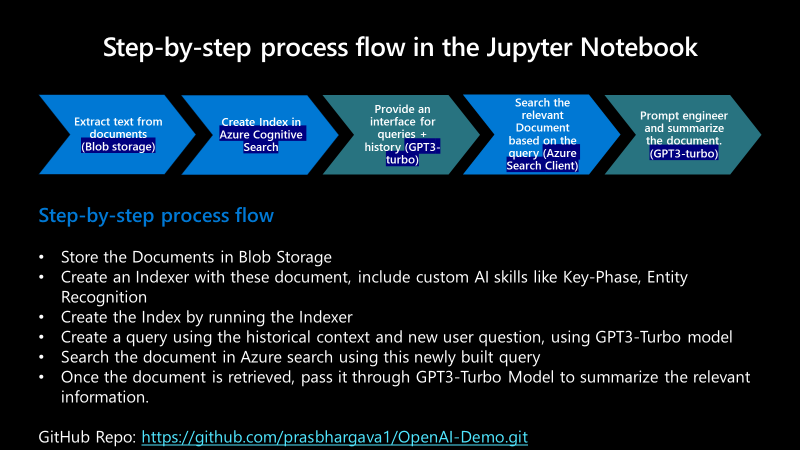

# Import the Relevant Libraries

In [1]:
import os
import io
import openai
from azure.identity import DefaultAzureCredential
from azure.search.documents import SearchClient
from dotenv import load_dotenv


In [2]:
import os
from os.path import join, dirname
from dotenv import load_dotenv
load_dotenv("C:\\Users\\prbhargava\\Documents\\OpenAIDEmo\\OpenAI-Demo\\env.txt")


True

# Add environment variables

In [3]:
AZURE_SEARCH_SERVICE = os.environ.get("AZURE_SEARCH_SERVICE")
AZURE_SEARCH_INDEX = os.environ.get("AZURE_SEARCH_INDEX")
AZURE_OPENAI_SERVICE = os.environ.get("AZURE_OPENAI_SERVICE")
AZURE_OPENAI_GPT_DEPLOYMENT = os.environ.get("AZURE_OPENAI_GPT_DEPLOYMENT")
AZURE_OPENAI_CHATGPT_DEPLOYMENT = os.environ.get("AZURE_OPENAI_CHATGPT_DEPLOYMENT")

In [4]:
print(AZURE_SEARCH_SERVICE)

acsopenidmo


# Add variables related to the Azure search fields

In [5]:
KB_FIELDS_CONTENT = os.environ.get("KB_FIELDS_CONTENT")
KB_FIELDS_CATEGORY = os.environ.get("KB_FIELDS_CATEGORY")
KB_FIELDS_SOURCEPAGE = os.environ.get("KB_FIELDS_SOURCEPAGE")

# Fetch Azure credentials

In [6]:
azure_credential = DefaultAzureCredential()

# Add Azure OpenAI endpoint and Key

In [7]:
openai.api_type = "azure"
openai.api_base = f"https://{AZURE_OPENAI_SERVICE}.openai.azure.com/"
openai.api_version = "2023-05-15" 

In [8]:
openai.api_key = os.environ.get("AOAI_KEY")

# Invoking the Azure Search Client

In [9]:
search_client = SearchClient(
    endpoint=f"https://{AZURE_SEARCH_SERVICE}.search.windows.net",
    index_name=AZURE_SEARCH_INDEX,
    credential=azure_credential)

# Now the Real Fun begins! 
Ask a question based on the input stories that are indexed in Azure Search. 

In [10]:
history="Who played the character Walter White in the series Breaking Bad?"

In [11]:
question="Who was his accomplice in the series?"

# Create a prompt to generate a completion with the new user query and previous queries

In [12]:
query_prompt_template = """As an assistant, generate a search query based on history and new user query.
        If the history is not there, return the query as it is.
        Do not add any new information outside what is asked.
    Chat History:
    {chat_history}
    Question:
    {question}
    Search query:
    """
query_prompt=query_prompt_template.format(chat_history=history,question=question)
response = openai.ChatCompletion.create(
    engine=AZURE_OPENAI_CHATGPT_DEPLOYMENT, 
    messages=[
        {"role": "system", "content": query_prompt_template},
        {"role": "user", "content": query_prompt}
    ],
    temperature=0.1
)


Timeout: Request timed out: HTTPSConnectionPool(host='openaidmo1.openai.azure.com', port=443): Read timed out. (read timeout=600)

In [ ]:
print(response)

# Fetch the generated question, with proper context, from the Chat Response

In [ ]:
q = response['choices'][0]['message']['content']
query=q.split(':')[-1].rstrip('\"')
print(query)

# Use the Search Client to search for the relevant document in the Knowledge base

In [ ]:
from azure.core.credentials import AzureKeyCredential
key = os.environ.get("KB_KEY")
credential = AzureKeyCredential(key)
client = SearchClient(endpoint=f"https://{AZURE_SEARCH_SERVICE}.search.windows.net",
                      index_name=AZURE_SEARCH_INDEX,
                      credential=credential)

In [ ]:
r = client.search(query, filter=None, top=1)
results = [(doc['content']) for doc in r]
try:
    content=results[0][0:2500]
except:
    content=results[0:2500]

In [ ]:
print(content)

# Create another prompt that will use the fetched document and summarize the the content with meaningful response.

In [ ]:
prompt_prefix = """<|im_start|>system
    Provide a summary of the source document by capturing the gist from the 
    query provided.
    Do not add anything which is not mentioned in the source document.
    Only provide the summary of the part of document that is relavant to the query.
    Sources:
    {sources}
    Query:
    {query}
    <|im_end|>
    """
try:
    prompt=prompt_prefix.format(sources=content,query=query)
except:
    prompt=prompt_prefix.format(sources=str(content),query=query)

# Call the ChatCompletion function to summarize the content

In [ ]:
completion = openai.ChatCompletion.create(
    engine=AZURE_OPENAI_CHATGPT_DEPLOYMENT, 
    messages=[
        {"role": "system", "content": prompt_prefix},
        {"role": "user", "content": prompt}
        ],
    temperature=0.1, 
    max_tokens=50, 
)


In [ ]:
q2 = completion['choices'][0]['message']['content']

# Print the meaningful summary.

In [ ]:
print(q2)

# End 

# 

# 

# 

In [ ]:
import openai
import re
import requests
import sys
from num2words import num2words
import os
import pandas as pd
import numpy as np
from openai.embeddings_utils import get_embedding, cosine_similarity
from transformers import GPT2TokenizerFast

In [ ]:
def normalize_text(s, sep_token = " \n "):
    s = re.sub(r'\s+',  ' ', s).strip()
    s = re.sub(r". ,","",s)
    # remove all instances of multiple spaces
    s = s.replace("..",".")
    s = s.replace(". .",".")
    s = s.replace("\n", "")
    s = s.strip()
    
    return s


In [ ]:
norm_query=normalize_text(query)

In [ ]:
norm_answer = normalize_text(q2)

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
norm_query_token=tokenizer.encode(norm_query)
norm_answer_token=tokenizer.encode(norm_answer)

In [ ]:
len(norm_query_token)

In [ ]:
len(norm_answer_token)

In [ ]:
embed_query=get_embedding(norm_query,engine=AZURE_OPENAI_GPT_DEPLOYMENT)
embed_answer=get_embedding(norm_answer,engine=AZURE_OPENAI_GPT_DEPLOYMENT)

In [ ]:
similarity=cosine_similarity(embed_query,embed_answer)

In [ ]:
print(similarity)

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
combined_sentence=[query+q2]
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(combined_sentence))

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()